In [1]:
import numpy as np

seed=42

np.random.seed = seed

In [2]:
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import tensorflow as tf
from skimage.morphology import label
import numpy as np
import pandas as pd
from skimage.transform import resize
from keras import regularizers

from keras.models import Model, load_model
from keras.layers import Input,UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D,MaxPool2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler
from keras import backend as K
import numpy as np
from keras.optimizers import Adam
import matplotlib.pyplot as plt


print('okay')

okay


Using TensorFlow backend.


In [3]:
# Set some parameters
height = 32*4
width = 32*4
IMG_CHANNELS = 1
no=30
seed = 42

In [4]:
dataset=np.load(r'../input/npy_file/npy_file/dataset.npy',allow_pickle=True)
mask=np.load(r'../input/npy_file/npy_file/mask_set.npy',allow_pickle=True)

print('okay')

okay


In [5]:
x_data=[]

y_data=[]
    

for i in range(len(dataset)):
    
    img=cv2.resize(dataset[i],(width,height),interpolation = cv2.INTER_AREA)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    x_data.append(img)
    
    mas=cv2.resize(mask[i],(width,height),interpolation = cv2.INTER_AREA)
    mas = (mas - np.min(mas)) / (np.max(mas) - np.min(mas))
    y_data.append(mas)

In [6]:
x_data=np.array(x_data)
y_data=np.array(y_data)

In [7]:
x_data.shape,y_data.shape

((3064, 128, 128), (3064, 128, 128))

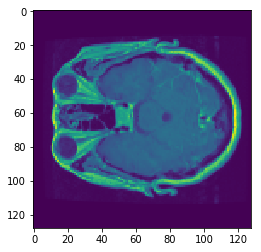

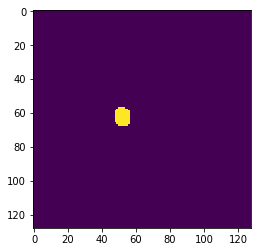

In [8]:
plt.imshow(x_data[10])
plt.show()

plt.imshow(y_data[10])
plt.show()

In [9]:
x_data = x_data.reshape(-1,height,width,1)
y_data = y_data.reshape(-1,height,width,1)

In [10]:
x_trainset, x_test, y_trainset, y_test = train_test_split(x_data, y_data, test_size = 0.1)

In [11]:
x_train,x_val,y_train,y_val=train_test_split(x_data, y_data, test_size = 0.2)

In [12]:
x_train[1].shape

(128, 128, 1)

In [13]:
y_data.shape

(3064, 128, 128, 1)

In [14]:
batchsize=8*2

print('okay')

okay


In [15]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.0005):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [16]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.0005):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [18]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [19]:
# Build U-Net model
inputs = Input(shape=(height,width,1))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])

print('okay')

okay


In [20]:
model.compile(optimizer=Adam(2e-4),loss='binary_crossentropy', metrics=[my_iou_metric])

In [21]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(zca_whitening = False,rotation_range = 90,
                                   width_shift_range = 0.2,height_shift_range = 0.2,
                                   brightness_range = [0.5, 1.5],shear_range = 0.2,
                                   zoom_range = 0.2,horizontal_flip = True,
                                   vertical_flip = True)

In [22]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 1,mode='min',
                          restore_best_weights = True)

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

# we put our call backs into a callback list
callbacks = [earlystop, reduce_lr]

In [ ]:
output =model.fit(x_train, y_train,batch_size=batchsize,validation_data=(x_val, y_val),epochs=20,verbose=1)

Train on 2451 samples, validate on 613 samples
Epoch 1/20
2451/2451 [==============================] - 103s 42ms/step - loss: 0.0960 - my_iou_metric: 0.0000e+00 - val_loss: 0.1308 - val_my_iou_metric: 0.0000e+00
Epoch 2/20
2451/2451 [==============================] - 98s 40ms/step - loss: 0.0587 - my_iou_metric: 1.1180e-04 - val_loss: 0.0896 - val_my_iou_metric: 4.0657e-04
Epoch 3/20
2451/2451 [==============================] - 96s 39ms/step - loss: 0.0531 - my_iou_metric: 0.0191 - val_loss: 0.0836 - val_my_iou_metric: 0.0081
Epoch 4/20
2451/2451 [==============================] - 96s 39ms/step - loss: 0.0470 - my_iou_metric: 0.0634 - val_loss: 0.0614 - val_my_iou_metric: 0.0366
Epoch 5/20
2451/2451 [==============================] - 96s 39ms/step - loss: 0.0413 - my_iou_metric: 0.0920 - val_loss: 0.0484 - val_my_iou_metric: 0.0615
Epoch 6/20
2451/2451 [==============================] - 96s 39ms/step - loss: 0.0374 - my_iou_metric: 0.1169 - val_loss: 0.0456 - val_my_iou_metric: 0.0754


In [ ]:
plt.plot(output.history['loss'], color='b')
plt.plot(output.history['val_loss'], color='r')
plt.title('classifier loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(output.history['my_iou_metric'], color='b')
plt.plot(output.history['val_my_iou_metric'], color='r')
plt.title('classifier iou_metric')
plt.ylabel('iou_metric')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
print('training complete')

In [ ]:
import cv2
import random

num=random.randint(0,x_test.shape[0]-1)

np.seterr(divide='ignore', invalid='ignore')

test_img=x_test[num]

test_img = cv2.resize(test_img,(height,width),interpolation = cv2.INTER_AREA)

test_img.shape

In [ ]:
x_test.shape[0]

In [ ]:
np.max(test_img)

In [ ]:
test_img = np.expand_dims(test_img, axis=-1)
test_img.shape
test_img = np.expand_dims(test_img, axis=0)

In [ ]:
results = model.predict(test_img,batch_size=None, verbose=0, steps=1)

results.shape

In [ ]:
ix=random.randint(0,x_test.shape[0]-1)
results_t=model.predict(x_val)
preds_train_t = (results_t > 0.5).astype(np.uint8)
#preds_train_t=preds_train_t.reshape((height,width))
iou_metric(np.squeeze(y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

In [ ]:
from matplotlib import pyplot as plt

results=np.reshape(results,(height,width))

results.shape

In [ ]:
test_image=np.reshape(test_img,(height,width))

In [ ]:
actual_mask=y_test[num]

In [ ]:
actual_mask.shape

In [ ]:
np.unique(results)

In [ ]:
results.shape

In [ ]:
from scipy import stats 
a = results.flatten()
m = a.mean(axis=0) 
sd = a.std(axis = 0, ddof = 0) 
np.where(sd == 0, 0, m / sd) 

In [ ]:
resized = cv2.resize(results, (height,width), interpolation = cv2.INTER_AREA)

In [ ]:
print(num)

plt.imshow(np.reshape(test_img,(height,width)),cmap='gray')
plt.title('actual image')
plt.show()

plt.imshow(np.reshape(resized,(height,width)),cmap='gray')
plt.title('results')
plt.show()

plt.imshow(np.reshape(actual_mask,(height,width)),cmap='gray')
plt.title('actual mask')
plt.show()

In [ ]:
results.shape

In [ ]:
snr_y_data=[]

for i in range(1848):
    a = y_data[i].flatten()
    m = a.mean(axis=0) 
    sd = a.std(axis = 0, ddof = 0) 
    value=np.where(sd == 0, 0, m / sd)
    snr_y_data.append(value)

In [ ]:
sum(snr_y_data)/1848

In [ ]:
max_no=np.max(results)

min_no=np.min(results)

valu=list(np.unique(results))

In [ ]:
length=len(valu)

length

In [ ]:
valu[length-1]

In [ ]:
results1=results>valu[length-250]

In [ ]:
plt.imshow(np.reshape(results1,(height,width)),cmap='gray')
plt.title('results')
plt.show()

plt.imshow(np.reshape(actual_mask,(height,width)),cmap='gray')
plt.title('actual mask')
plt.show()